ใน ep.4 นี้เราจะมาลองสร้าง Dataset ของตัวเอง เพื่อเทรนโมเดล 

* Acne สิว 
* Melasma ฝ้า
* Freckle กระ

เราเข้าไปที่ Google Images แล้ว Search รูปที่ต้องการ เลือกเป็น Size ใหญ่ แล้วกดปุ่ม <kbd>F12</kbd> แล้วก็อปปี้โค้ดด้านล่างไปแปะ แล้วกด <kbd>Enter</kbd>

`urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

เราจะได้ไฟล์ที่เก็บรายชื่อ URL ของรูปทั้งหมดในผลการค้นหา ให้เรา Save และนำมา Upload ไว้ใน Folder data/skin

# 0. Magic Commands


In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [20]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล

ให้เราใส่ชื่อไฟล์แ และชื่อ Folder ให้ถูกต้องตาม Category ที่เราจะทำ Classifier ในที่นี้ เรามี 3 หมวดหมู่ คือ สิว acne, ฝ้า melasma, กระ freckle

In [21]:
folder = 'acne'
file = 'urls_acne.txt'

In [22]:
folder = 'melasma'
file = 'urls_melasma.txt'

In [23]:
folder = 'freckle'
file = 'urls_freckle.txt'

สั่งให้สร้าง Folder และ Download รูป ตาม URL ที่อยู่ในไฟล์ จำนวน max_pics = 300 รูป ไปใส่ไว้ Folder dest

*หมายเหตุ ให้เรา 1. เลือก Category ในช่องด้านบน แล้วกด Run แล้วจึง 2. มาเลือกช่องด่านล่าง สั่ง Run เพื่อ Download*

In [24]:
path = Path('data/skin')
download_path = path/'downloads'
dest = download_path/folder
dest.mkdir(parents=True, exist_ok=True)

In [11]:
download_images(path/file, dest, max_pics=300)

วนลูปตรวจสอบไฟล์ เนื่องจาก Google Image บอกว่ามีรูปนี้อยู่ แต่จริง ๆ รูปอาจจะไม่ได้อยู่แล้ว บางทีเราจะได้ไฟล์ขยะมาแทน

In [25]:
classes = ['melasma','freckle','acne']

In [26]:
for c in classes:
    print(c)
    verify_images(download_path/c, delete=True, max_size=720)

# 3. เตรียมข้อมูล

ใน ep ก่อน ๆ เราใช้ขนาดรูปแค่ 224, 299, 28 Pixel เท่านั้น แต่ในเคสนี้ ถ้ารูปเล็กเกินไปจะทำให้เห็นแต่รูปร่างรวม ๆ ไม่เห็นผิว ไม่เห็นความผิดปกติที่เกิดขึ้นบนผิว เราจึงปรับความละเอียดของรูปที่ใช้เทรน เพิ่มเป็น 512 การปรับจูนพารามิเตอร์ของโมเดลแบบนี้ เรียกว่า Hyperparameter Tuning มีหลายตัวด้วยกัน ซึ่งเราจะอธิบายต่อไป

In [46]:
batchsize = 64
np.random.seed(55)

databunch = ImageDataBunch.from_folder(download_path, train='.', 
                                       valid_pct=0.2, 
                                       ds_tfms=get_transforms(), 
                                       size=512, bs=batchsize).normalize(imagenet_stats)

# ### อ่านให้จบ ข้อ 8 ก่อน ค่อยย้อนขึ้นมาดูใหม่
# databunch = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', 
#                                        valid_pct=0.2, 
#                                        ds_tfms=get_transforms(), 
#                                        size=512, bs=batchsize).normalize(imagenet_stats)

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [43]:
databunch.classes

['acne', 'freckle', 'melasma']

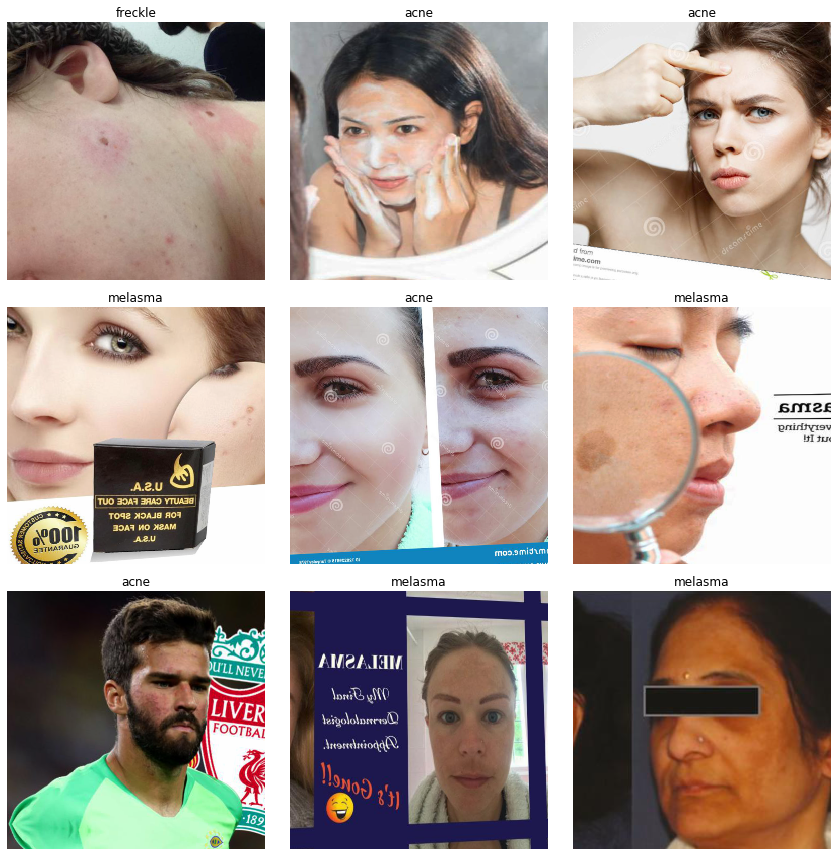

In [44]:
databunch.show_batch(rows=3, figsize=(12, 12))

In [45]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['acne', 'freckle', 'melasma'], 3, 519, 129)

## คุณภาพของรูปจากอินเตอร์เน็ต

จะเห็นได้ว่ารูปที่ดาวน์โหลดมาจาก Google Image คุณภาพค่อนข้างหลากหลาย มีทั้งรูปสต็อก รูปศิลปะ รูปโฆษณา รูปดารา รูปผลิตภัณฑ์ รูปวิชาการ etc. แต่ไม่เป็นไรเราจะลองเทรนโมเดลด้วยรูปเหล่านี้ดู

# 4. สร้างโมเดล



In [31]:
learner = cnn_learner(databunch, models.resnet34, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Cycle

In [32]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.180008,1.104135,0.512346,06:37


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [33]:
learner.save('01d-resnet34-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [22]:
# learner.load('01d-resnet34-1')

# 6. เทรนต่อ

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


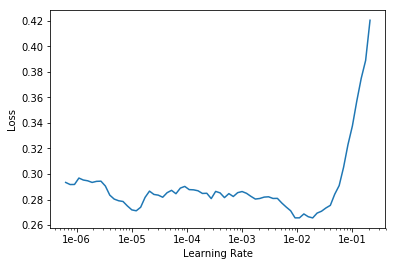

In [23]:
learner.lr_find()
learner.recorder.plot()

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(6, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.312647,0.384527,0.839623,00:13
1,0.281137,0.445947,0.820755,00:12
2,0.256846,0.451822,0.811321,00:11
3,0.241840,0.427219,0.858491,00:11
4,0.232591,0.409830,0.849057,00:11


## สำเร็จแล้ว ##

เพียงแค่เวลา 3 นาทีเศษ เราเทรน Model ตามวิธีเดิม ด้วยรูปที่คุณภาพหลายหลาย จำนวนแค่ 300 x 3 รูป 

แต่โมเดลสามารถเรียนรู้จากรูปเท่าที่มี แยกแยะ Noise ที่ไม่เกี่ยวข้องออกไป ทำให้เราได้ accuracy ประมาณ 0.85 หรือ ความแม่นยำประมาณ 85%


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [ ]:
learner.save('01d-resnet34-2')

In [ ]:
# learner.load('01d-resnet34-2')

# 7. ดูผลลัพธ์

In [34]:
interpretation = ClassificationInterpretation.from_learner(learner)

สั่งให้ plot_top_losses คือ แสดง record ที่ ค่า loss มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด 9 อันดับแรก 

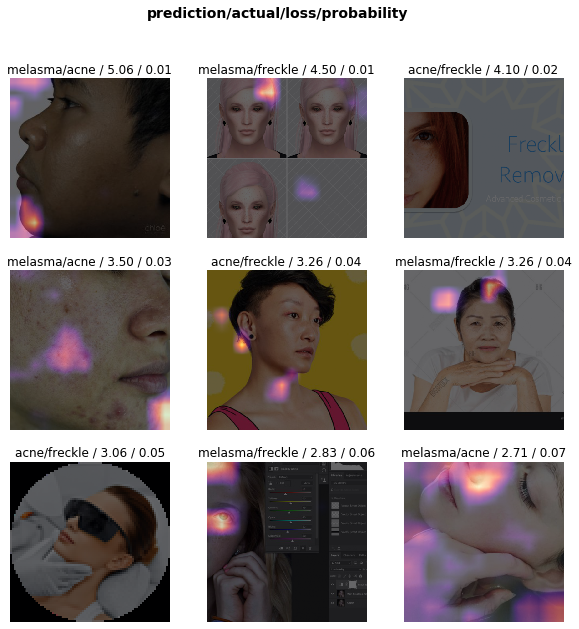

In [35]:
interpretation.plot_top_losses(9, figsize=(10,10))

จะเห็นได้ว่ายากจริง ๆ เนื่องจากสภาพผิวมีตั้งแต่เริ่มเกิดอาการ ไปจนถึงเป็นเรื้อรัง

จากรูป plot_top_losses มีการแสดง heat map สีแดง ให้ดูด้วยว่า model พิจารณาเน้นจากส่วนไหนของรูปเป็นหลัก เรียกว่า Attention ที่ไว้เราจะอธิบายต่อไป


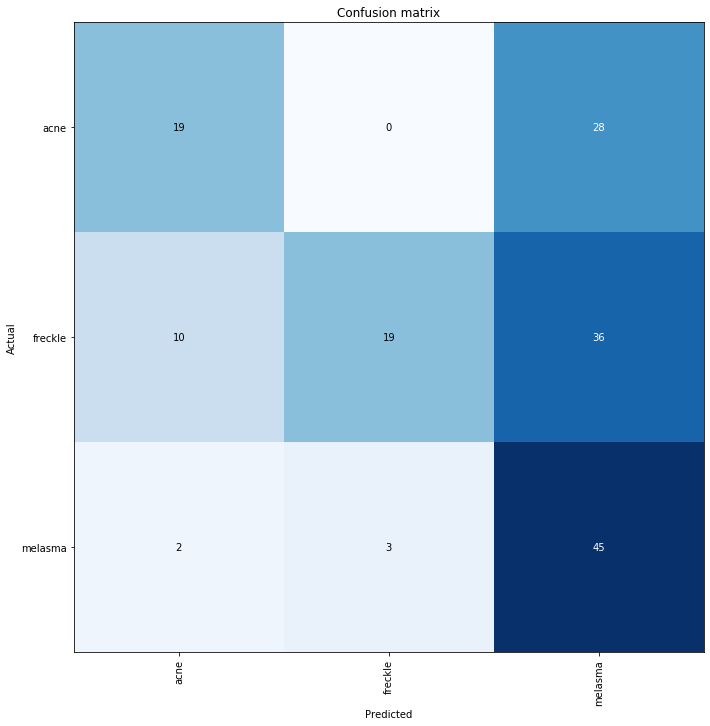

In [36]:
interpretation.plot_confusion_matrix(figsize=(10,10), dpi=72)

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [37]:
interpretation.most_confused(min_val=2)

[('freckle', 'melasma', 36),
 ('acne', 'melasma', 28),
 ('freckle', 'acne', 10),
 ('melasma', 'freckle', 3),
 ('melasma', 'acne', 2)]

# 8. Clean ข้อมูล แล้วลองเทรนใหม่

In [38]:
from fastai.widgets import *

เลือกรูปที่เรียงตาม Loss มากที่สุด หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิดจากมากไปน้อย

In [39]:
ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)

เปิดโปรแกรม Image Cleaner 

ให้เลือกรูปทุกรูปที่มีปัญหา กด <kbd>Delete</kbd> ใต้รูป และ กด <kbd>Next</kbd>

In [40]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

รูปซ้ำก็ทำให้โมเดลมีปัญหาได้เช่นกัน เลือกรูปที่น่าจะซ้ำมากที่สุด เรียงจากมากไปน้อย

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learner, ds_type=DatasetType.Valid)

เปิดโปรแกรม Image Cleaner 

ให้เลือกรูปทุกรูปที่มีปัญหา กด <kbd>Delete</kbd> ใต้รูป และ กด <kbd>Next</kbd>

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

## ลองเทรนใหม่

เมื่อทำเสร็จ จะเปิดไฟล์ที่ชื่อว่า cleaned.csv ขึ้นมา 

ใน [3. การเตรียมข้อมูล](#3.-%E0%B9%80%E0%B8%95%E0%B8%A3%E0%B8%B5%E0%B8%A2%E0%B8%A1%E0%B8%82%E0%B9%89%E0%B8%AD%E0%B8%A1%E0%B8%B9%E0%B8%A5) ให้เราสร้าง databunch from_csv จากไฟล์นี้แทน from_folder แล้วลองเทรนใหม่
``

# 8. สรุป


เราสามารถสร้าง Data Set ชุดข้อมูลขึ้นมาได้เอง ตามที่เราสนใจ หรือเรามีความเชี่ยวชาญ ไม่ว่าจะเป็น การแพทย์ การผลิต การเกษตร การเงิน แฟชั่น etc.

* การเทรนโมเดลหลัก ๆ จะคล้าย ๆ กัน แต่ก็จะมีการทำ Hyperparameter Tuning ตามแต่ละข้อมูล
* โมเดลสามารถเอาชนะ Noise ในข้อมูลได้ระดับหนึ่ง ข้อมูลไม่จำเป็นต้อง Perfect การเสียเวลาทำให้ข้อมูล Perfect อาจจะไม่คุ้มกับ Performance ที่เพิ่มขึ้น
* 


# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 2](https://course.fast.ai/videos/?lesson=2)